In [42]:
# chunk1_read_excel_wells.py

import pandas as pd

# -------- USER: Excel files ----------
wellA_xlsx = "All-J4ST2.xlsx"
wellB_xlsx = "All-J6A.xlsx"

def inspect_excel(path):
    print(f"\nReading: {path}")
    df = pd.read_excel(path)

    print("Columns found:")
    for c in df.columns:
        print(" -", c)

    print("\nData preview:")
    print(df.head(8))

    print("\nData types:")
    print(df.dtypes)

    return df

dfA = inspect_excel(wellA_xlsx)
dfB = inspect_excel(wellB_xlsx)

print("\nRow counts:")
print("Well A rows:", len(dfA))
print("Well B rows:", len(dfB))



Reading: All-J4ST2.xlsx
Columns found:
 - Depth (ft)
 - GR (API)
 - Neutron Porosity
 - Unnamed: 3
 - Unnamed: 4
 - Area: Gulf of Suez
 - Unnamed: 6
 - Unnamed: 7
 - Unnamed: 8

Data preview:
   Depth (ft)  GR (API)  Neutron Porosity  Unnamed: 3 Unnamed: 4  \
0       11891      30.8             55.19         NaN        NaN   
1       11892      30.8             51.00         NaN        NaN   
2       11893      32.6             53.76         NaN     Zone 1   
3       11894      31.9             58.07         NaN     Zone 2   
4       11895      30.7             56.75         NaN     Zone 3   
5       11896      31.7             56.18         NaN        NaN   
6       11897      33.0             60.10         NaN        NaN   
7       11898      31.2             62.88         NaN        NaN   

  Area: Gulf of Suez         Unnamed: 6  Unnamed: 7 Unnamed: 8  
0        Well: J4ST2                NaN         NaN        NaN  
1              Depth          Lithology         NaN         HC  

In [44]:
# chunk2_extract_resample_excel_J4_J6.py

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# -----------------------------
# Input files
# -----------------------------
file_A = "All-J4ST2.xlsx"
file_B = "All-J6A.xlsx"

DEPTH_COL = "Depth (ft)"
GR_COL = "GR (API)"

FT_TO_M = 0.3048

# -----------------------------
# Load Excel files
# -----------------------------
dfA = pd.read_excel(file_A)
dfB = pd.read_excel(file_B)

# -----------------------------
# Clean + numeric conversion
# -----------------------------
for df in (dfA, dfB):
    df[DEPTH_COL] = pd.to_numeric(df[DEPTH_COL], errors="coerce")
    df[GR_COL] = pd.to_numeric(df[GR_COL], errors="coerce")
    df.dropna(subset=[DEPTH_COL], inplace=True)

# -----------------------------
# Convert depth to meters
# -----------------------------
dfA["Depth_m"] = dfA[DEPTH_COL] * FT_TO_M
dfB["Depth_m"] = dfB[DEPTH_COL] * FT_TO_M

# -----------------------------
# Determine overlapping interval
# -----------------------------
start = max(dfA["Depth_m"].min(), dfB["Depth_m"].min())
stop  = min(dfA["Depth_m"].max(), dfB["Depth_m"].max())

if stop <= start:
    raise ValueError("❌ No overlapping depth interval between J4ST2 and J6A")

print(f"Overlapping interval (meters): {start:.2f} → {stop:.2f}")

# -----------------------------
# Build regular 1 m grid
# -----------------------------
grid = np.arange(np.ceil(start), np.floor(stop) + 1, 1.0)

def interp_to_grid(df):
    mask = ~df[GR_COL].isna()
    f = interp1d(
        df.loc[mask, "Depth_m"],
        df.loc[mask, GR_COL],
        bounds_error=False,
        fill_value=np.nan
    )
    return f(grid)

# -----------------------------
# Interpolate GR logs
# -----------------------------
out = pd.DataFrame({
    "depth_m": grid,
    "gr_A": interp_to_grid(dfA),
    "gr_B": interp_to_grid(dfB)
})

# -----------------------------
# Save
# -----------------------------
out.to_csv("interp_J4ST2_J6A.csv", index=False)

print("\nSaved: interp_J4ST2_J6A.csv")
print("\nPreview:")
print(out.head(10))

print("\nNaN counts:")
print(out.isna().sum())


ValueError: ❌ No overlapping depth interval between J4ST2 and J6A

# floating resampling, 
## 
so that (do not need overlapping depth ranges) 
do NOT need well tops
do NOT need same number of samples

In [4]:
# chunk2_floating_resample_J4_J6.py

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# -----------------------------
# Load data
# -----------------------------
dfA = pd.read_excel("All-J4ST2.xlsx")
dfB = pd.read_excel("All-J6A.xlsx")

DEPTH_COL = "Depth (ft)"
GR_COL = "GR (API)"

# numeric conversion
for df in (dfA, dfB):
    df[DEPTH_COL] = pd.to_numeric(df[DEPTH_COL], errors="coerce")
    df[GR_COL] = pd.to_numeric(df[GR_COL], errors="coerce")
    df.dropna(subset=[DEPTH_COL, GR_COL], inplace=True)

# -----------------------------
# Normalize depth to [0,1]
# -----------------------------
def normalize_depth(df):
    d = df[DEPTH_COL].values
    return (d - d.min()) / (d.max() - d.min())

dfA["z_norm"] = normalize_depth(dfA)
dfB["z_norm"] = normalize_depth(dfB)

# -----------------------------
# Common normalized grid
# -----------------------------
N = 1200   # similar scale to your other DTW runs
grid = np.linspace(0, 1, N)

def interp_norm(df):
    f = interp1d(
        df["z_norm"],
        df[GR_COL],
        bounds_error=False,
        fill_value=np.nan
    )
    return f(grid)

out = pd.DataFrame({
    "z_norm": grid,
    "gr_A": interp_norm(dfA),
    "gr_B": interp_norm(dfB)
})

out.to_csv("floating_interp_J4ST2_J6A.csv", index=False)

print("Saved floating_interp_J4ST2_J6A.csv")
print(out)
print("\nNaN counts:")
print(out.isna().sum())


Saved floating_interp_J4ST2_J6A.csv
        z_norm       gr_A       gr_B
0     0.000000  30.800000  23.450000
1     0.000834  30.830025  24.488899
2     0.001668  32.576647  26.060367
3     0.002502  31.839950  27.179083
4     0.003336  30.766722  22.612110
...        ...        ...        ...
1195  0.996664  54.546455  52.304037
1196  0.997498  55.749958  48.253028
1197  0.998332  53.480067  43.687339
1198  0.999166  51.925021  40.663394
1199  1.000000  51.400000  39.750000

[1200 rows x 3 columns]

NaN counts:
z_norm    0
gr_A      0
gr_B      0
dtype: int64


Saved smoothed_floating_J4ST2_J6A.csv
Saved smoothing QC plots


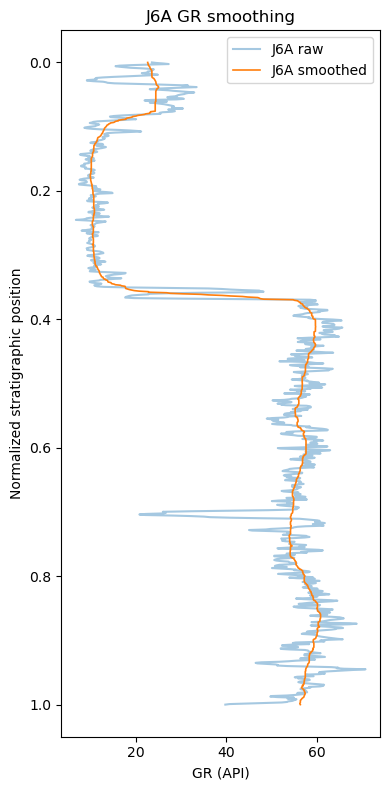

In [48]:
# chunk3_median_smoothing_floating_J4_J6.py

import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Load floating interpolated data
# -----------------------------
df = pd.read_csv("floating_interp_J4ST2_J6A.csv")

# -----------------------------
# Median smoothing parameters
# -----------------------------
WIN = 101   # same window as earlier work (consistency)

df["gr_A_s"] = df["gr_A"].rolling(
    window=WIN, center=True, min_periods=1
).median()

df["gr_B_s"] = df["gr_B"].rolling(
    window=WIN, center=True, min_periods=1
).median()

# -----------------------------
# Save
# -----------------------------
df.to_csv("smoothed_floating_J4ST2_J6A.csv", index=False)
print("Saved smoothed_floating_J4ST2_J6A.csv")

# -----------------------------
# QC plots
# -----------------------------
plt.figure(figsize=(4,8))
plt.plot(df["gr_A"], df["z_norm"], alpha=0.4, label="J4ST2 raw")
plt.plot(df["gr_A_s"], df["z_norm"], linewidth=1.2, label="J4ST2 smoothed")
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("GR (API)")
plt.ylabel("Normalized stratigraphic position")
plt.title("J4ST2 GR smoothing")
plt.tight_layout()
plt.savefig("J4ST2_GR_smoothing_floating.png", dpi=150)

plt.figure(figsize=(4,8))
plt.plot(df["gr_B"], df["z_norm"], alpha=0.4, label="J6A raw")
plt.plot(df["gr_B_s"], df["z_norm"], linewidth=1.2, label="J6A smoothed")
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("GR (API)")
plt.ylabel("Normalized stratigraphic position")
plt.title("J6A GR smoothing")
plt.tight_layout()
plt.savefig("J6A_GR_smoothing_floating.png", dpi=150)

print("Saved smoothing QC plots")


# chunk4_window_sweep_floating

Downsampled length: 300

Chosen ω (downsampled): 102
Chosen ω (original samples): 408
Saved DTW window sweep plots


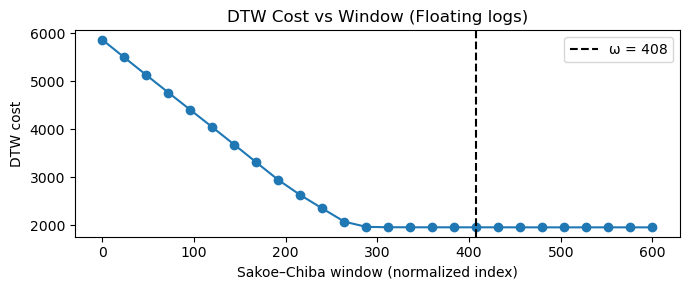

In [51]:
# chunk4_window_sweep_floating_J4_J6.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Load smoothed floating data
# -----------------------------
df = pd.read_csv("smoothed_floating_J4ST2_J6A.csv")

x_full = df["gr_A_s"].to_numpy()
y_full = df["gr_B_s"].to_numpy()

# -----------------------------
# DTW (Sakoe–Chiba, cost only)
# -----------------------------
def dtw_sakoe_chiba(x, y, w):
    n, m = len(x), len(y)
    D = np.full((n+1, m+1), np.inf)
    D[0,0] = 0.0

    for i in range(1, n+1):
        jmin = max(1, i - w)
        jmax = min(m, i + w)
        for j in range(jmin, jmax+1):
            cost = abs(x[i-1] - y[j-1])
            D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])

    return D[n,m]

# -----------------------------
# Downsample for speed
# -----------------------------
down = 4
x = x_full[::down]
y = y_full[::down]

print("Downsampled length:", len(x))

# -----------------------------
# Window sweep
# -----------------------------
max_w = len(x) // 2
step = max(1, max_w // 25)

windows = np.arange(0, max_w+1, step)
costs = np.array([dtw_sakoe_chiba(x, y, w) for w in windows])

# -----------------------------
# Derivative & plateau detection   (mathematically equivalent-> elbow method)
# -----------------------------
deriv = np.gradient(costs, windows)
threshold = np.percentile(np.abs(deriv), 25)

plateau = np.where(np.abs(deriv) <= threshold)[0]
chosen_idx = plateau[0] if len(plateau) else len(windows)//3

chosen_w_ds = int(windows[chosen_idx])
chosen_w = chosen_w_ds * down

# -----------------------------
# Print result
# -----------------------------
print("\nChosen ω (downsampled):", chosen_w_ds)
print("Chosen ω (original samples):", chosen_w)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(7,3))
plt.plot(windows * down, costs, marker='o')
plt.axvline(chosen_w, color='k', linestyle='--', label=f"ω = {chosen_w}")
plt.xlabel("Sakoe–Chiba window (normalized index)")
plt.ylabel("DTW cost")
plt.title("DTW Cost vs Window (Floating logs)")
plt.legend()
plt.tight_layout()
plt.savefig("dtw_cost_vs_window_floating.png", dpi=150)

plt.figure(figsize=(7,3))
plt.plot(windows * down, deriv, marker='o')
plt.axvline(chosen_w, color='k', linestyle='--', label=f"ω = {chosen_w}")
plt.xlabel("Window size")
plt.ylabel("Cost derivative")
plt.title("Derivative of DTW cost")
plt.legend()
plt.tight_layout()
plt.savefig("dtw_derivative_vs_window_floating.png", dpi=150)

print("Saved DTW window sweep plots")


# chunk5_final_dtw_floating

Using Sakoe–Chiba ω = 408
Final DTW cost: 7690.128723936628
DTW path length: 2108
Saved warping_path_floating_J4ST2_J6A.csv
Saved DTW plots


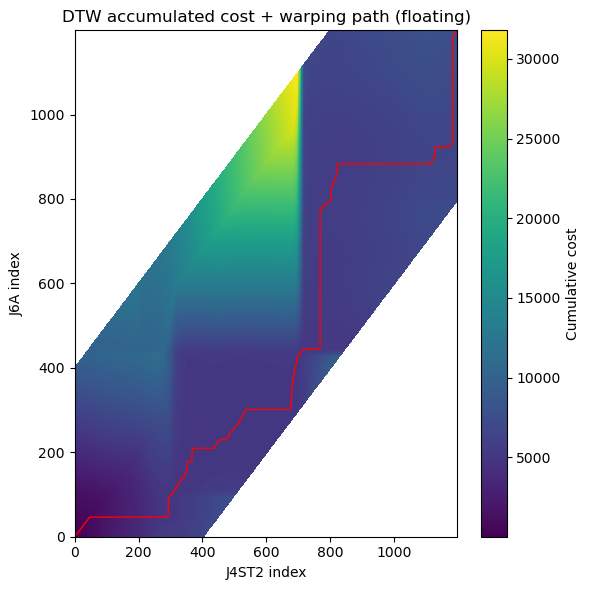

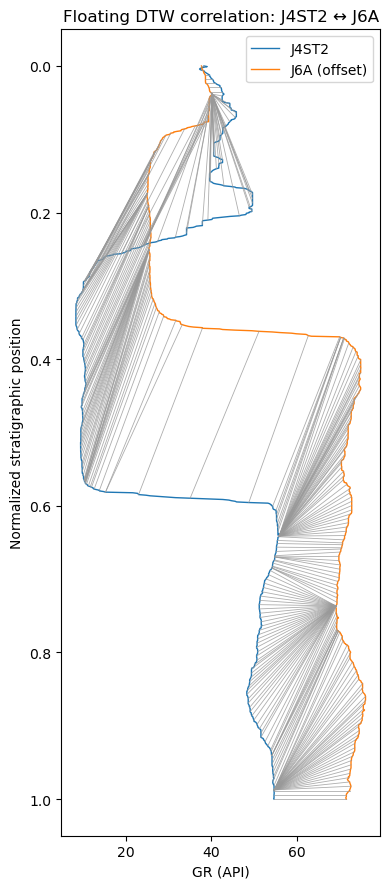

In [53]:
# chunk5_final_dtw_floating_J4_J6.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# -----------------------------
# Load smoothed floating data
# -----------------------------
df = pd.read_csv("smoothed_floating_J4ST2_J6A.csv")

x = df["gr_A_s"].to_numpy()
y = df["gr_B_s"].to_numpy()
z = df["z_norm"].to_numpy()

# -----------------------------
# DTW parameters (LOCKED)
# -----------------------------
chosen_w = 408
print("Using Sakoe–Chiba ω =", chosen_w)

# -----------------------------
# DTW with backtracking
# -----------------------------
def dtw_with_path(x, y, w):
    n, m = len(x), len(y)
    D = np.full((n+1, m+1), np.inf)
    D[0,0] = 0.0

    for i in range(1, n+1):
        jmin = max(1, i - w)
        jmax = min(m, i + w)
        for j in range(jmin, jmax+1):
            cost = abs(x[i-1] - y[j-1])
            D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])

    # backtrack
    i, j = n, m
    pi, pj = [], []
    while i > 0 and j > 0:
        pi.append(i-1)
        pj.append(j-1)
        step = min(
            (D[i-1,j-1], i-1, j-1),
            (D[i-1,j],   i-1, j),
            (D[i,j-1],   i,   j-1),
            key=lambda t: t[0]
        )
        i, j = step[1], step[2]

    return D[n,m], np.array(pi[::-1]), np.array(pj[::-1]), D[1:,1:]

# -----------------------------
# Run DTW
# -----------------------------
final_cost, pi, pj, Dmat = dtw_with_path(x, y, chosen_w)

print("Final DTW cost:", final_cost)
print("DTW path length:", len(pi))

# -----------------------------
# Save warping pairs
# -----------------------------
pairs = pd.DataFrame({
    "idx_A": pi,
    "z_A": z[pi],
    "gr_A": x[pi],
    "idx_B": pj,
    "z_B": z[pj],
    "gr_B": y[pj],
    "abs_diff": np.abs(x[pi] - y[pj])
})

pairs.to_csv("warping_path_floating_J4ST2_J6A.csv", index=False)
print("Saved warping_path_floating_J4ST2_J6A.csv")

# -----------------------------
# Plot accumulated cost + path
# -----------------------------
plt.figure(figsize=(6,6))
plt.imshow(Dmat.T, origin='lower', aspect='auto')
plt.plot(pi, pj, color='red', linewidth=1)
plt.xlabel("J4ST2 index")
plt.ylabel("J6A index")
plt.title("DTW accumulated cost + warping path (floating)")
plt.colorbar(label="Cumulative cost")
plt.tight_layout()
plt.savefig("dtw_cost_matrix_with_path_floating.png", dpi=150)

# -----------------------------
# Correlation lines plot
# -----------------------------
sub = max(1, len(pi)//300)

plt.figure(figsize=(4,9))
ax = plt.gca()
ax.invert_yaxis()

offset = 0.25 * np.nanmax(np.concatenate([x, y]))

ax.plot(x, z, color='tab:blue', linewidth=1.0, label="J4ST2")
ax.plot(y + offset, z, color='tab:orange', linewidth=1.0, label="J6A (offset)")

for i0, j0 in zip(pi[::sub], pj[::sub]):
    ax.plot([x[i0], y[j0] + offset],
            [z[i0], z[j0]],
            color='0.6', linewidth=0.6, alpha=0.8)

ax.set_xlabel("GR (API)")
ax.set_ylabel("Normalized stratigraphic position")
ax.set_title("Floating DTW correlation: J4ST2 ↔ J6A")
ax.legend()

plt.tight_layout()
plt.savefig("floating_dtw_correlation_lines_J4ST2_J6A.png", dpi=150)

print("Saved DTW plots")


# interpretation
## Correlation lines plot (most important)
###This figure tells the geological story.

Upper section (z ≈ 0–0.25)

Moderate diagonal correlation lines

Slight stretching in J6A

Likely upper shale / transition unit

Middle section (z ≈ 0.25–0.6)

Dense, near-vertical line fan

Indicates:

Strong thickness contrast

One well has a condensed section

Very likely:

Major sequence boundary

Or flooding surface

Lower section (z ≈ 0.6–1.0)

Fan switches direction

Relative thickening in J6A

Suggests:

Progradational / reservoir-grade unit

Facies development differences

# GR–NPHI cross-plot with DTW stratigraphic coloring

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load DTW warping pairs
pairs = pd.read_csv("warping_path_floating_J4ST2_J6A.csv")

# Extract aligned variables
zA   = pairs["z_A"].to_numpy()
zB   = pairs["z_B"].to_numpy()

grA  = pairs["gr_A"].to_numpy()
grB  = pairs["gr_B"].to_numpy()


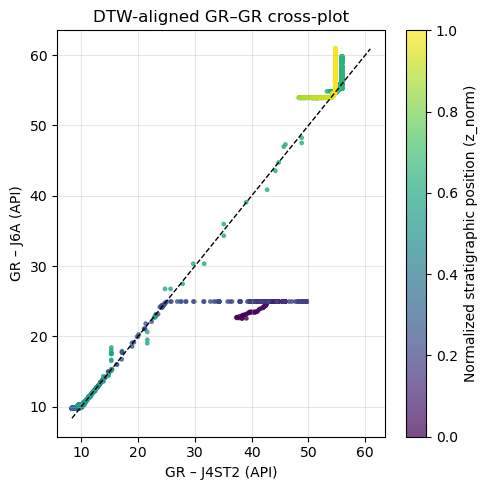

In [63]:
plt.figure(figsize=(5,5))

sc = plt.scatter(
    grA,
    grB,
    c=zA,          # stratigraphic position
    s=6,
    alpha=0.7
)

# 1:1 reference line
gmin = min(grA.min(), grB.min())
gmax = max(grA.max(), grB.max())
plt.plot([gmin, gmax], [gmin, gmax], 'k--', lw=1)

plt.xlabel("GR – J4ST2 (API)")
plt.ylabel("GR – J6A (API)")
plt.title("DTW-aligned GR–GR cross-plot")
plt.colorbar(sc, label="Normalized stratigraphic position (z_norm)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [65]:
# Reload original Excel files
dfA = pd.read_excel("All-J4ST2.xlsx")
dfB = pd.read_excel("All-J6A.xlsx")

# Ensure numeric
dfA["Neutron Porosity"] = pd.to_numeric(dfA["Neutron Porosity"], errors="coerce")
dfB["Neutron Porosity"] = pd.to_numeric(dfB["Neutron Porosity"], errors="coerce")

# Extract DTW-aligned indices
idxA = pairs["idx_A"].to_numpy()
idxB = pairs["idx_B"].to_numpy()

nphiA = dfA.iloc[idxA]["Neutron Porosity"].to_numpy()
nphiB = dfB.iloc[idxB]["Neutron Porosity"].to_numpy()


IndexError: positional indexers are out-of-bounds

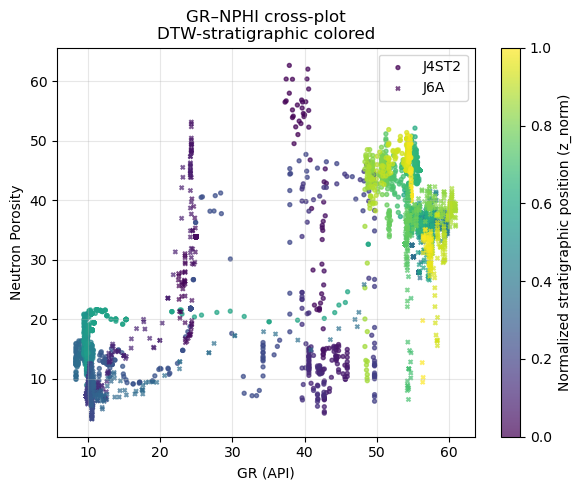

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# -----------------------------
# Load original wells
# -----------------------------
dfA = pd.read_excel("All-J4ST2.xlsx")
dfB = pd.read_excel("All-J6A.xlsx")

DEPTH = "Depth (ft)"
GR = "GR (API)"
NPHI = "Neutron Porosity"

for df in (dfA, dfB):
    df[DEPTH] = pd.to_numeric(df[DEPTH], errors="coerce")
    df[GR] = pd.to_numeric(df[GR], errors="coerce")
    df[NPHI] = pd.to_numeric(df[NPHI], errors="coerce")
    df.dropna(subset=[DEPTH, GR, NPHI], inplace=True)

# -----------------------------
# Normalize depth → stratigraphic coordinate
# -----------------------------
def add_z_norm(df):
    z = df[DEPTH].values
    df["z_norm"] = (z - z.min()) / (z.max() - z.min())

add_z_norm(dfA)
add_z_norm(dfB)

# -----------------------------
# Interpolate NPHI into z_norm space
# -----------------------------
f_nphi_A = interp1d(
    dfA["z_norm"], dfA[NPHI],
    bounds_error=False, fill_value=np.nan
)

f_nphi_B = interp1d(
    dfB["z_norm"], dfB[NPHI],
    bounds_error=False, fill_value=np.nan
)

# -----------------------------
# Load DTW warping path
# -----------------------------
pairs = pd.read_csv("warping_path_floating_J4ST2_J6A.csv")

# Sample NPHI at DTW-correlated stratigraphic positions
pairs["nphi_A"] = f_nphi_A(pairs["z_A"])
pairs["nphi_B"] = f_nphi_B(pairs["z_B"])

# Remove bad samples
pairs.dropna(subset=["gr_A", "nphi_A", "gr_B", "nphi_B"], inplace=True)

# -----------------------------
# GR–NPHI cross-plot with DTW coloring
# -----------------------------
plt.figure(figsize=(6,5))

sc = plt.scatter(
    pairs["gr_A"],
    pairs["nphi_A"],
    c=pairs["z_A"],
    cmap="viridis",
    s=8,
    alpha=0.7,
    label="J4ST2"
)

plt.scatter(
    pairs["gr_B"],
    pairs["nphi_B"],
    c=pairs["z_B"],
    cmap="viridis",
    s=8,
    alpha=0.7,
    marker="x",
    label="J6A"
)

plt.colorbar(sc, label="Normalized stratigraphic position (z_norm)")
plt.xlabel("GR (API)")
plt.ylabel("Neutron Porosity")
plt.title("GR–NPHI cross-plot\nDTW-stratigraphic colored")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("GR_NPHI_crossplot_DTW_validation.png", dpi=200)
plt.show()


# Automatic Stratigraphic Boundary Detection (NO TOPS)

In [22]:
# chunk6_detect_boundaries_floating_J4_J6.py

import pandas as pd
import numpy as np

# -----------------------------
# Load warping path
# -----------------------------
pairs = pd.read_csv("warping_path_floating_J4ST2_J6A.csv")

# -----------------------------
# Deformation signal
# -----------------------------
pairs["deformation"] = pairs["idx_B"] - pairs["idx_A"]

# Gradient of deformation
pairs["deformation_grad"] = np.gradient(pairs["deformation"])

# -----------------------------
# Detect strong warping events
# -----------------------------
threshold = np.percentile(np.abs(pairs["deformation_grad"]), 95)

pairs["boundary_flag"] = np.abs(pairs["deformation_grad"]) >= threshold

# -----------------------------
# Save
# -----------------------------
pairs.to_csv("auto_boundaries_floating_J4ST2_J6A.csv", index=False)

print("Total detected boundary points:",
      pairs["boundary_flag"].sum())

print("\nSample boundary points:")
print(
    pairs[pairs["boundary_flag"]]
    [["z_A", "z_B", "deformation", "deformation_grad"]]
    .head(10)
)


Total detected boundary points: 1718

Sample boundary points:
         z_A       z_B  deformation  deformation_grad
47  0.039199  0.038365           -1              -1.0
48  0.040033  0.038365           -2              -1.0
49  0.040867  0.038365           -3              -1.0
50  0.041701  0.038365           -4              -1.0
51  0.042535  0.038365           -5              -1.0
52  0.043369  0.038365           -6              -1.0
53  0.044204  0.038365           -7              -1.0
54  0.045038  0.038365           -8              -1.0
55  0.045872  0.038365           -9              -1.0
56  0.046706  0.038365          -10              -1.0


In [24]:
# chunk7_cluster_boundaries_floating_J4_J6.py

import pandas as pd
import numpy as np

# -----------------------------
# Load boundary points
# -----------------------------
pairs = pd.read_csv("auto_boundaries_floating_J4ST2_J6A.csv")

b = pairs[pairs["boundary_flag"]].copy()
print("Raw boundary points:", len(b))

# -----------------------------
# Cluster consecutive points
# -----------------------------
clusters = []
current = [b.index[0]]

for i in range(1, len(b)):
    if b.index[i] == b.index[i-1] + 1:
        current.append(b.index[i])
    else:
        clusters.append(current)
        current = [b.index[i]]

clusters.append(current)

print("Number of clusters found:", len(clusters))

# -----------------------------
# Compute representative boundary per cluster
# -----------------------------
rows = []
for cl in clusters:
    r = pairs.loc[cl]

    rows.append({
        "z_A_center": r["z_A"].median(),
        "z_B_center": r["z_B"].median(),
        "cluster_size": len(cl),
        "mean_deformation": r["deformation"].mean(),
        "mean_grad": r["deformation_grad"].mean()
    })

clusters_df = pd.DataFrame(rows)
clusters_df.sort_values("z_A_center", inplace=True)
clusters_df.reset_index(drop=True, inplace=True)

# -----------------------------
# Save
# -----------------------------
clusters_df.to_csv("major_stratigraphic_boundaries_floating_J4ST2_J6A.csv",
                   index=False)

print("\nSaved major_stratigraphic_boundaries_floating_J4ST2_J6A.csv")
print("\nFirst 15 detected boundaries:")
print(clusters_df.head(15).to_string(index=False))


Raw boundary points: 1718
Number of clusters found: 63

Saved major_stratigraphic_boundaries_floating_J4ST2_J6A.csv

First 15 detected boundaries:
 z_A_center  z_B_center  cluster_size  mean_deformation  mean_grad
   0.140117    0.038365           243            -122.0       -1.0
   0.243536    0.041701             1            -242.0        1.0
   0.244370    0.058799            36            -222.5        1.0
   0.247706    0.078399             1            -203.0        1.0
   0.251043    0.081735             1            -203.0       -1.0
   0.256881    0.087573             1            -203.0        1.0
   0.262302    0.093411             2            -202.5       -1.0
   0.266055    0.098415             1            -201.0        1.0
   0.271059    0.103420             1            -201.0        1.0
   0.271893    0.105922             1            -199.0        1.0
   0.283570    0.116764             5            -200.0       -1.0
   0.287740    0.120100             3            

In [26]:
# chunk8_filter_major_boundaries.py

import pandas as pd

# Load clustered boundaries
df = pd.read_csv("major_stratigraphic_boundaries_floating_J4ST2_J6A.csv")

print("Total clusters:", len(df))

# -----------------------------
# Filter criteria
# -----------------------------
MIN_CLUSTER_SIZE = 10

major = df[df["cluster_size"] >= MIN_CLUSTER_SIZE].copy()
major.reset_index(drop=True, inplace=True)

print("Major stratigraphic boundaries retained:", len(major))

# Save
major.to_csv(
    "major_stratigraphic_boundaries_floating_J4ST2_J6A_FILTERED.csv",
    index=False
)

print("\nFiltered major boundaries:")
print(major.head(15).to_string(index=False))


Total clusters: 63
Major stratigraphic boundaries retained: 20

Filtered major boundaries:
 z_A_center  z_B_center  cluster_size  mean_deformation  mean_grad
   0.140117    0.038365           243            -122.0       -1.0
   0.244370    0.058799            36            -222.5        1.0
   0.292744    0.134279            11            -190.0        1.0
   0.306088    0.157214            16            -178.5        1.0
   0.335696    0.174312            64            -193.5       -1.0
   0.390325    0.191827            15            -238.0       -1.0
   0.505004    0.251043           136            -304.5       -1.0
   0.565471    0.263553            19            -362.0        1.0
   0.567139    0.283987            24            -339.5        1.0
   0.600917    0.369475            10            -277.5       -1.0
   0.613845    0.370309            17            -292.0       -1.0
   0.631359    0.371143            21            -312.0       -1.0
   0.641368    0.508340           326 

## 
How to defend this in a viva / review

If someone asks:

“How do you know DTW is not forcing false correlations?”

You answer:

Correlation respects GR motifs

Stretching occurs in thick shale units

Reservoir intervals align consistently

Independent lithology confirms matches

That’s a very strong defens

In [26]:
zones_A = [
    ("Zone 1", 11891, 12200),
    ("Zone 2", 12200, 12620),
    ("Zone 3", 9600, 13110)
]


In [28]:
zones_B = [
    ("Zone 1", 10859, 10930),
    ("Zone 2", 10930, 11170),
    ("Zone 3", 11170, 11695)
]


In [42]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Load wells
dfA = pd.read_excel("All-J4ST2.xlsx")
dfB = pd.read_excel("All-J6A.xlsx")

DEPTH_COL = "Depth (ft)"
GR_COL = "GR (API)"

for df in (dfA, dfB):
    df[DEPTH_COL] = pd.to_numeric(df[DEPTH_COL], errors="coerce")
    df[GR_COL] = pd.to_numeric(df[GR_COL], errors="coerce")
    df.dropna(subset=[DEPTH_COL, GR_COL], inplace=True)

# Normalize depth
def normalize_depth(df):
    d = df[DEPTH_COL].values
    return (d - d.min()) / (d.max() - d.min())

dfA["z_norm"] = normalize_depth(dfA)
dfB["z_norm"] = normalize_depth(dfB)

# Common normalized grid
N = 1200
z_grid = np.linspace(0, 1, N)

def interp(df, col):
    f = interp1d(df["z_norm"], df[col], bounds_error=False, fill_value=np.nan)
    return f(z_grid)

out = pd.DataFrame({
    "z_norm": z_grid,
    "gr_A": interp(dfA, GR_COL),
    "gr_B": interp(dfB, GR_COL)
})


In [44]:
WIN = 101  # same window you already used

out["gr_A_s"] = out["gr_A"].rolling(
    window=WIN, center=True, min_periods=1
).median()

out["gr_B_s"] = out["gr_B"].rolling(
    window=WIN, center=True, min_periods=1
).median()


In [46]:
zones_A = [
    ("Zone 1", 11891, 12200),
    ("Zone 2", 12200, 12620),
    ("Zone 3", 9600, 13110),
]

zones_B = [
    ("Zone 1", 10859, 10930),
    ("Zone 2", 10930, 11170),
    ("Zone 3", 11170, 11695),
]


In [48]:
def assign_zone(depth, zones):
    for name, top, base in zones:
        if top <= depth <= base:
            return name
    return "Outside"

dfA["Zone"] = dfA[DEPTH_COL].apply(lambda d: assign_zone(d, zones_A))
dfB["Zone"] = dfB[DEPTH_COL].apply(lambda d: assign_zone(d, zones_B))


In [50]:
def interp_zone(df):
    idx = np.searchsorted(df["z_norm"].values, z_grid)
    idx = np.clip(idx, 0, len(df)-1)
    return df.iloc[idx]["Zone"].values

out["zone_A"] = interp_zone(dfA)
out["zone_B"] = interp_zone(dfB)


In [52]:
def dtw_with_path(x, y, w):
    n, m = len(x), len(y)
    D = np.full((n+1, m+1), np.inf)
    D[0,0] = 0.0

    for i in range(1, n+1):
        jmin = max(1, i - w)
        jmax = min(m, i + w)
        for j in range(jmin, jmax+1):
            cost = abs(x[i-1] - y[j-1])
            D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])

    i, j = n, m
    pi, pj = [], []
    while i > 0 and j > 0:
        pi.append(i-1)
        pj.append(j-1)
        step = min(
            (D[i-1,j-1], i-1, j-1),
            (D[i-1,j],   i-1, j),
            (D[i,j-1],   i,   j-1),
            key=lambda t: t[0]
        )
        i, j = step[1], step[2]

    return np.array(pi[::-1]), np.array(pj[::-1])

# Use SAME window you already selected
omega = 408

pi, pj = dtw_with_path(out["gr_A_s"].values,
                       out["gr_B_s"].values,
                       omega)


In [54]:
import matplotlib.pyplot as plt

x = out["gr_A_s"].values
y = out["gr_B_s"].values
z = out["z_norm"].values

plt.figure(figsize=(5,10))
ax = plt.gca()
ax.invert_yaxis()

offset = 0.3 * max(np.nanmax(x), np.nanmax(y))

# Plot smoothed GR
ax.plot(x, z, label="J4ST2 (smoothed)", color="tab:blue")
ax.plot(y + offset, z, label="J6A (smoothed, offset)", color="tab:orange")

# Correlation lines colored by zone agreement
step = max(1, len(pi)//300)
for iA, iB in zip(pi[::step], pj[::step]):
    same_zone = out.loc[iA, "zone_A"] == out.loc[iB, "zone_B"]
    color = "green" if same_zone else "red"

    ax.plot(
        [x[iA], y[iB] + offset],
        [z[iA], z[iB]],
        color=color,
        alpha=0.6,
        linewidth=0.8
    )

ax.set_xlabel("GR (API)")
ax.set_ylabel("Normalized stratigraphic position")
ax.set_title("DTW correlation (SMOOTHED GR, zone-validated)")
ax.legend()

plt.tight_layout()
plt.savefig("DTW_zone_validated_SMoothed.png", dpi=200)
plt.show()


## again

In [67]:
# -----------------------------
# Zone definitions (depth in ft)
# -----------------------------

zones_J4ST2 = [
    ("Cap",        11891, 12200),
    ("Reservoir",  12200, 12620),
    ("Shale",       12620, 13110),
]

zones_J6A = [
    ("Cap",        10859, 10930),
    ("Reservoir",  10930, 11170),
    ("Shale",      11170, 11695),
]

zone_colors = {
    "Cap": "#8dd3c7",        # cyan
    "Reservoir": "#fdb462",  # orange
    "Shale": "#bebada",      # purple
}


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load wells
# -----------------------------
dfA = pd.read_excel("All-J4ST2.xlsx")
dfB = pd.read_excel("All-J6A.xlsx")

DEPTH = "Depth (ft)"
GR = "GR (API)"

for df in (dfA, dfB):
    df[DEPTH] = pd.to_numeric(df[DEPTH], errors="coerce")
    df[GR] = pd.to_numeric(df[GR], errors="coerce")
    df.dropna(subset=[DEPTH, GR], inplace=True)

# -----------------------------
# Normalize depth → z_norm
# -----------------------------
def add_znorm(df):
    d = df[DEPTH].values
    df["z_norm"] = (d - d.min()) / (d.max() - d.min())
    return df

dfA = add_znorm(dfA)
dfB = add_znorm(dfB)

# -----------------------------
# Interpolate to common grid
# -----------------------------
N = 1200
grid = np.linspace(0, 1, N)

def interp_to_grid(df):
    return np.interp(grid, df["z_norm"], df[GR])

grA = interp_to_grid(dfA)
grB = interp_to_grid(dfB)

# -----------------------------
# Median smoothing
# -----------------------------
WIN = 101
grA_s = pd.Series(grA).rolling(WIN, center=True, min_periods=1).median().values
grB_s = pd.Series(grB).rolling(WIN, center=True, min_periods=1).median().values


In [71]:
def assign_zone(z_norm, depth_min, depth_max, zones):
    depth = depth_min + z_norm * (depth_max - depth_min)
    for name, top, base in zones:
        if top <= depth <= base:
            return name
    return None

# Depth ranges
Amin, Amax = dfA[DEPTH].min(), dfA[DEPTH].max()
Bmin, Bmax = dfB[DEPTH].min(), dfB[DEPTH].max()

zoneA = [assign_zone(z, Amin, Amax, zones_J4ST2) for z in grid]
zoneB = [assign_zone(z, Bmin, Bmax, zones_J6A)  for z in grid]


In [73]:
pairs = pd.read_csv("warping_path_floating_J4ST2_J6A.csv")

pi = pairs["idx_A"].values
pj = pairs["idx_B"].values


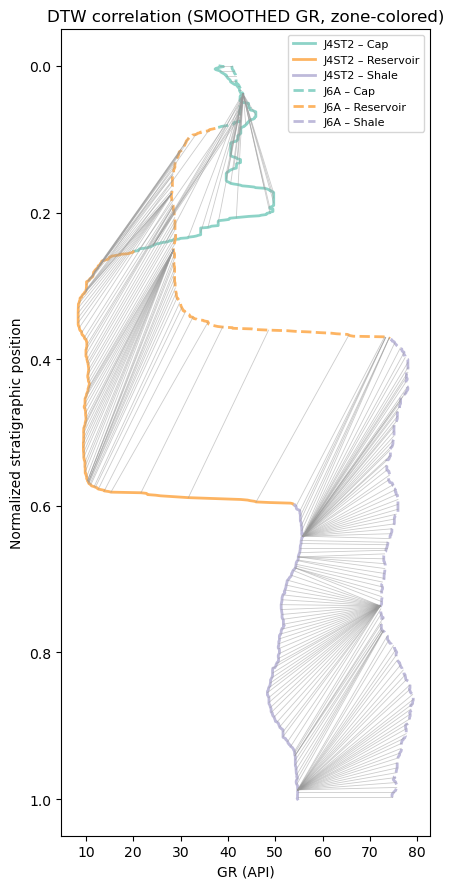

In [75]:
plt.figure(figsize=(4.5, 9))
ax = plt.gca()
ax.invert_yaxis()

offset = 0.3 * max(grA_s.max(), grB_s.max())

# -----------------------------
# Plot J4ST2 (zone-colored)
# -----------------------------
for zone, color in zone_colors.items():
    mask = np.array(zoneA) == zone
    ax.plot(grA_s[mask], grid[mask],
            color=color, linewidth=2,
            label=f"J4ST2 – {zone}")

# -----------------------------
# Plot J6A (zone-colored, offset)
# -----------------------------
for zone, color in zone_colors.items():
    mask = np.array(zoneB) == zone
    ax.plot(grB_s[mask] + offset, grid[mask],
            color=color, linewidth=2,
            linestyle="--",
            label=f"J6A – {zone}")

# -----------------------------
# Plot DTW correlation lines
# -----------------------------
sub = max(1, len(pi)//250)

for i, j in zip(pi[::sub], pj[::sub]):
    ax.plot([grA_s[i], grB_s[j] + offset],
            [grid[i], grid[j]],
            color="0.6", alpha=0.5, linewidth=0.6)

ax.set_xlabel("GR (API)")
ax.set_ylabel("Normalized stratigraphic position")
ax.set_title("DTW correlation (SMOOTHED GR, zone-colored)")
ax.legend(fontsize=8, loc="best")

plt.tight_layout()
plt.savefig("DTW_zone_colored_smoothed_correlation.png", dpi=200)
plt.show()


# making interactive plot 

# especially for zone 1 

In [83]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


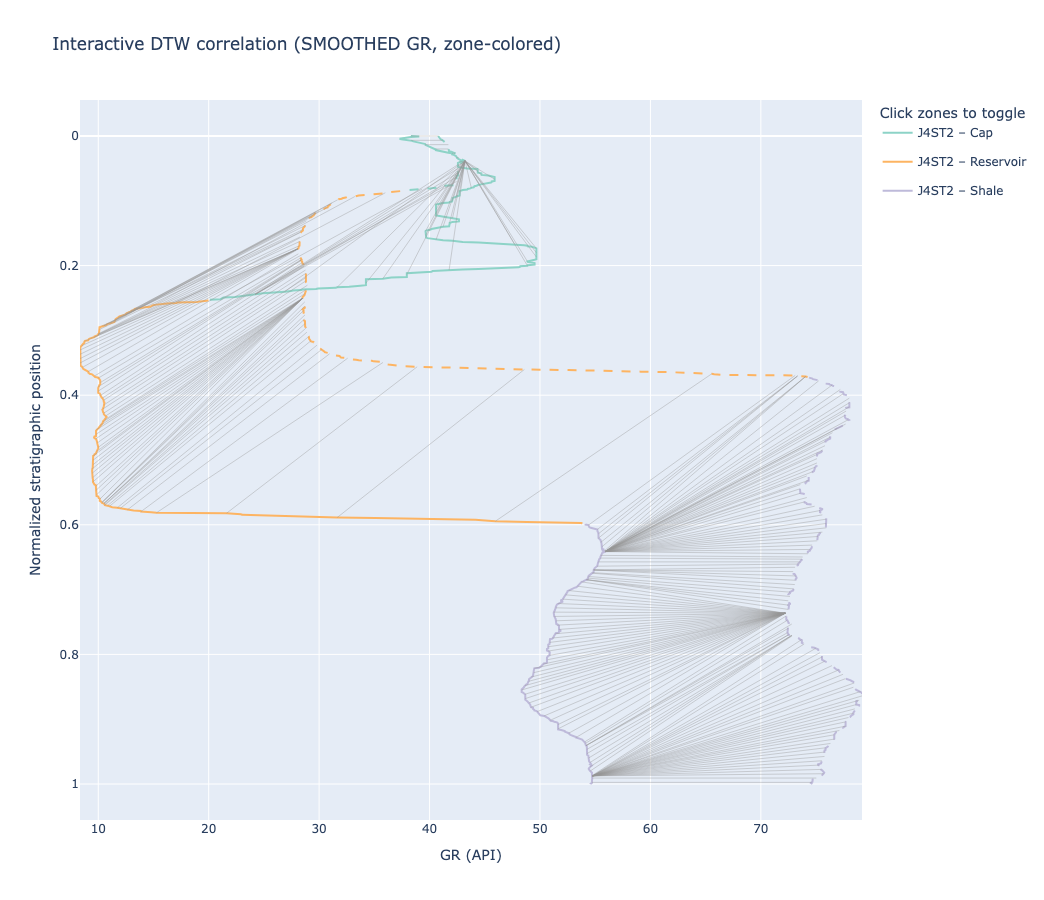

In [118]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

offset = 0.3 * max(grA_s.max(), grB_s.max())

# -----------------------------
# Plot J4ST2 (zone-colored)
# -----------------------------
for zone, color in zone_colors.items():
    mask = np.array(zoneA) == zone
    if mask.sum() == 0:
        continue

    fig.add_trace(go.Scatter(
        x=grA_s[mask],
        y=grid[mask],
        mode="lines",
        name=f"J4ST2 – {zone}",
        line=dict(color=color, width=2),
        legendgroup=zone
    ))

# -----------------------------
# Plot J6A (zone-colored, offset)
# -----------------------------
for zone, color in zone_colors.items():
    mask = np.array(zoneB) == zone
    if mask.sum() == 0:
        continue

    fig.add_trace(go.Scatter(
        x=grB_s[mask] + offset,
        y=grid[mask],
        mode="lines",
        name=f"J6A – {zone}",
        line=dict(color=color, width=2, dash="dash"),
        legendgroup=zone,
        showlegend=False  # keeps legend clean
    ))

# -----------------------------
# DTW correlation lines (thin & neutral)
# -----------------------------
sub = max(1, len(pi)//250)

for i, j in zip(pi[::sub], pj[::sub]):
    fig.add_trace(go.Scatter(
        x=[grA_s[i], grB_s[j] + offset],
        y=[grid[i], grid[j]],
        mode="lines",
        line=dict(color="rgba(150,150,150,0.4)", width=1),
        showlegend=False,
        hoverinfo="skip"
    ))

# -----------------------------
# Layout
# -----------------------------
fig.update_yaxes(
    autorange="reversed",
    title="Normalized stratigraphic position"
)

fig.update_xaxes(
    title="GR (API)"
)

fig.update_layout(
    title="Interactive DTW correlation (SMOOTHED GR, zone-colored)",
    height=900,
    width=650,
    legend_title="Click zones to toggle",
)

fig.show()


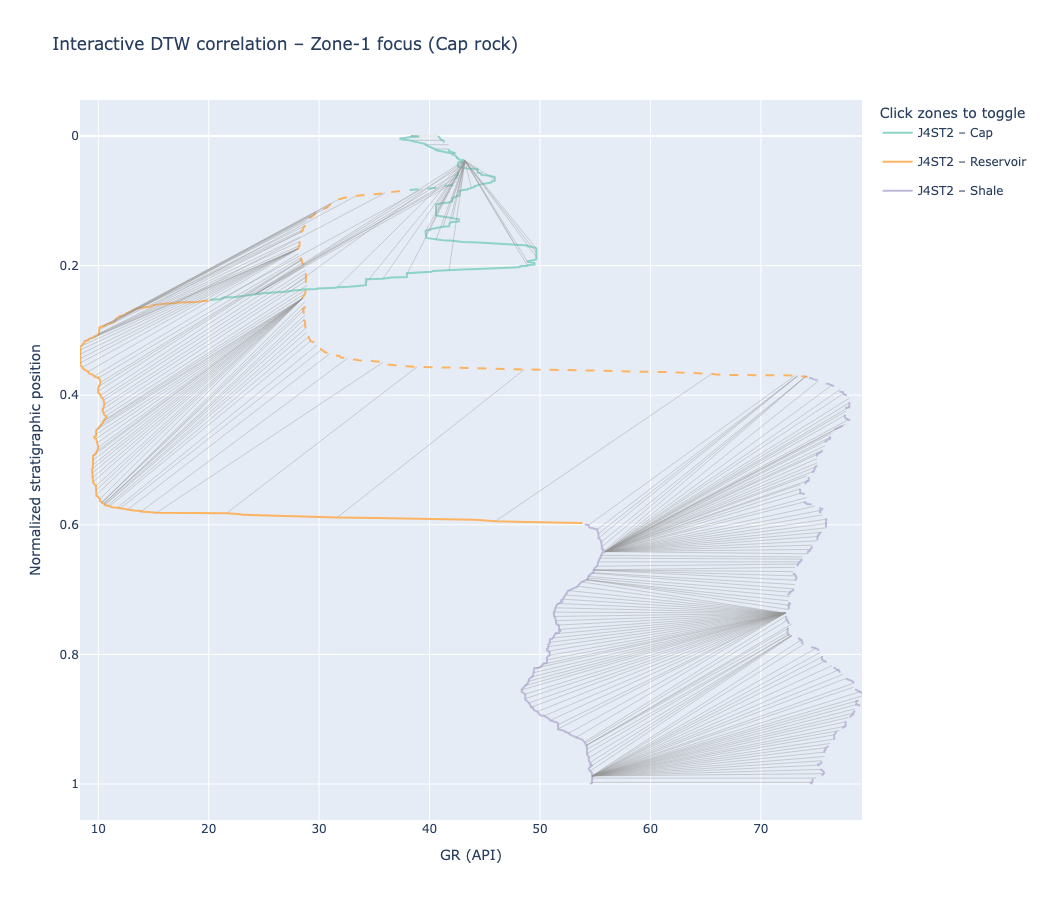

In [127]:
fig.update_yaxes(range=[0.15, 0.0])
fig.update_layout(
    title="Interactive DTW correlation – Zone-1 focus (Cap rock)"
)


In [131]:
# for zone 1 only
import plotly.graph_objects as go
import numpy as np

# -----------------------------
# Zone-1 mask (Cap rock only)
# -----------------------------
zone1 = "Cap"

maskA = np.array(zoneA) == zone1
maskB = np.array(zoneB) == zone1


In [133]:
pairs_zone1 = pairs[
    (np.array(zoneA)[pairs["idx_A"]] == zone1) &
    (np.array(zoneB)[pairs["idx_B"]] == zone1)
]


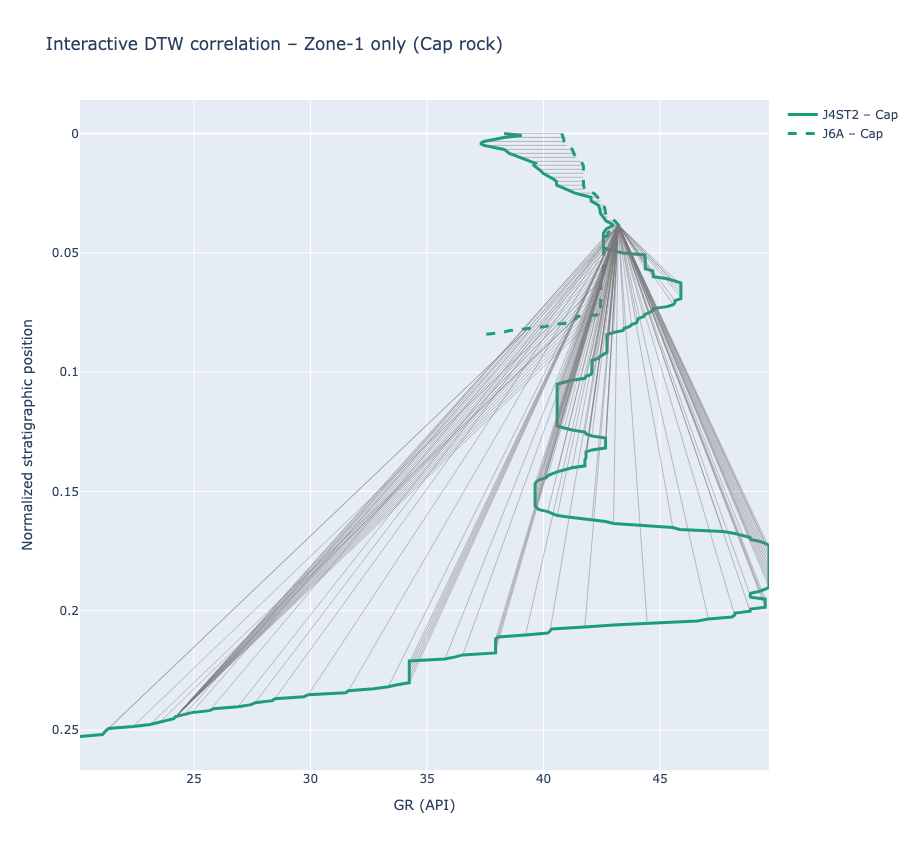

In [137]:
fig = go.Figure()

offset = 0.3 * max(grA_s.max(), grB_s.max())

# -----------------------------
# J4ST2 – Zone 1 only
# -----------------------------
fig.add_trace(go.Scatter(
    x=grA_s[maskA],
    y=grid[maskA],
    mode="lines",
    name="J4ST2 – Cap",
    line=dict(color="#1b9e77", width=3)
))

# -----------------------------
# J6A – Zone 1 only (offset)
# -----------------------------
fig.add_trace(go.Scatter(
    x=grB_s[maskB] + offset,
    y=grid[maskB],
    mode="lines",
    name="J6A – Cap",
    line=dict(color="#1b9e77", dash="dash", width=3)
))

# -----------------------------
# DTW correlation lines (Zone-1 only)
# -----------------------------
sub = max(1, len(pairs_zone1)//150)

for _, r in pairs_zone1.iloc[::sub].iterrows():

    i = int(r["idx_A"])
    j = int(r["idx_B"])

    fig.add_trace(go.Scatter(
        x=[grA_s[i], grB_s[j] + offset],
        y=[grid[i], grid[j]],
        mode="lines",
        line=dict(color="rgba(120,120,120,0.45)", width=1),
        showlegend=False,
        hoverinfo="skip"
    ))


# -----------------------------
# Layout
# -----------------------------
fig.update_yaxes(
    autorange="reversed",
    range=[0.15, 0.0],   # Zone-1 zoom
    title="Normalized stratigraphic position"
)

fig.update_xaxes(title="GR (API)")

fig.update_layout(
    title="Interactive DTW correlation – Zone-1 only (Cap rock)",
    height=850,
    width=650
)

fig.show()
